# Setup

## Imports

In [351]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import tensorflow as tf

## Variables

### Dataset

In [352]:
ds = tf.keras.utils.image_dataset_from_directory(
  "data",
  batch_size=None,
  label_mode="categorical",
  shuffle=False
)
class_names = ds.class_names

"""
Normalizing here smoothens many later processes, such as
- Visualization (no need to convert to int)
- Training (lower computation cost)
"""
def normalize(x, y):
  return x/255, y
ds = ds.map(normalize)

Found 1032 files belonging to 10 classes.


### Random

For deterministic results

In [353]:
def setRng():
  global rng
  rng = np.random.default_rng(2101432)
  return rng

rng = setRng()

def randint():
  return rng.integers(65535)

### Helpers

In [354]:
# Scaling Factor for Visualizations
sf = 2.5

def classInfos(ds):
  labels = [tf.argmax(label_categorical) for image, label_categorical in ds]
  unique_labels, class_counts = np.unique(labels, return_counts=True)
  return labels, unique_labels, class_counts

def filterByLabel(label):
  return lambda image, label_categorical: label_categorical[label] == 1

# Exploration

## Metadata

In [355]:
example_image = next(ds.take(1).as_numpy_iterator())[0]
image_shape = example_image.shape
target_size = image_shape[:2]

print(f"Image Shape: {image_shape}")

Image Shape: (256, 256, 3)


### Classes

In [356]:
num_classes = len(class_names)

num_classes_print = f"{num_classes} Classes"
print(num_classes_print, "-" * len(num_classes_print), sep="\n")

for label, class_name in enumerate(class_names):
  print(f"{label}: {class_name}")

10 Classes
----------
0: Carrot Cake
1: Chicken Rice
2: Congee
3: Hokkien Mee
4: Kaya Toast
5: Laksa
6: Lamb Soup
7: Nasi Lemak
8: Prata
9: Satay


#### Samples per class

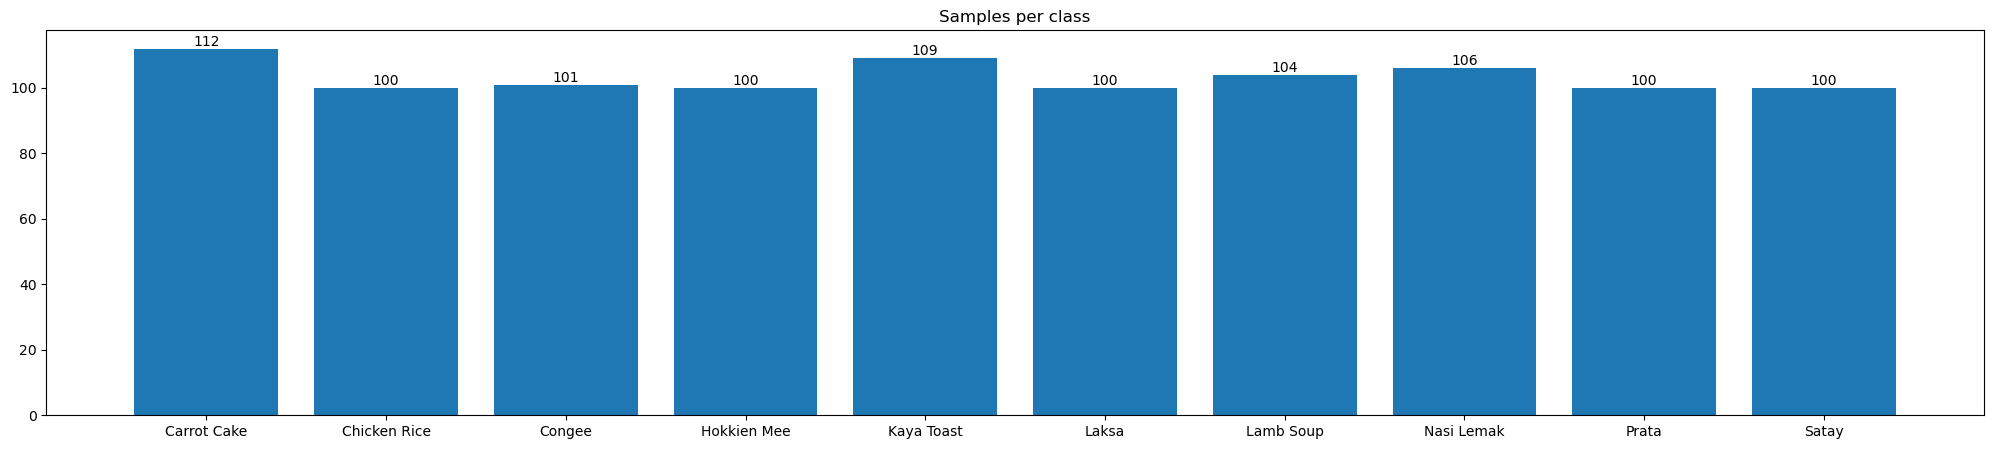

In [357]:
labels, unique_labels, class_counts = classInfos(ds)

plt.figure(figsize=(num_classes * sf, 5))
plt.bar_label(plt.bar(class_names, class_counts))
plt.title("Samples per class")
plt.show()

There seems to be a slight imbalance in samples per class

#### Examples by class

In [358]:
def examplesByClass(ds, examples_per_class, unique_labels=unique_labels):
  num_classes = len(unique_labels)
  plt.figure(figsize=(examples_per_class * sf, num_classes * sf))

  for label_i, label in enumerate(unique_labels):
    examples = ds.filter(filterByLabel(label)).take(examples_per_class)
    zero_index = label_i * examples_per_class + 1
    for example_i, (image, label_categorical) in enumerate(examples):
      plt.subplot(num_classes, examples_per_class, zero_index + example_i)
      plt.imshow(image)
      if example_i == 0:
        plt.title(class_names[label])
      plt.axis("off")

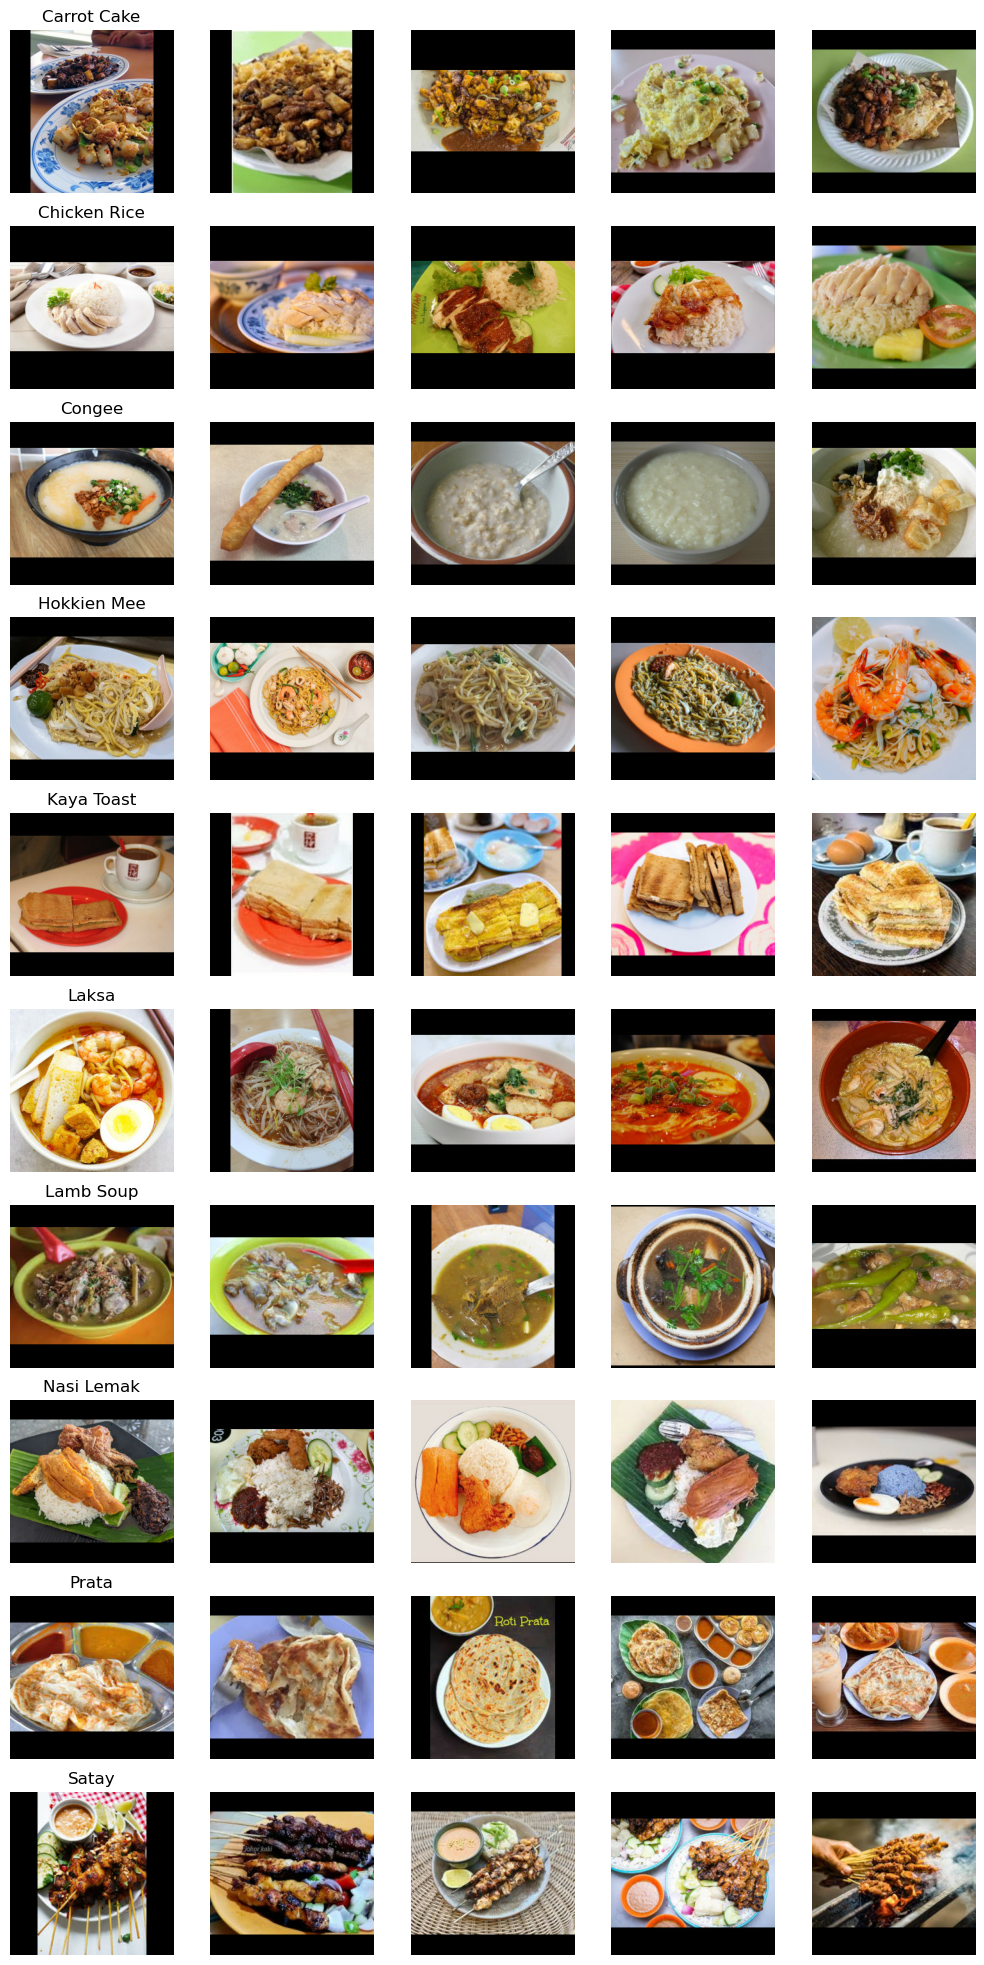

In [359]:
examplesByClass(ds, 5)

# Pre-processing

## Data Augmentation

In [360]:
def mapX(ds, map):
  return ds.map(lambda x, y: (map(x), y))

### Oversampling

In [361]:
def oversampleWAugmentation(ds, class_counts, target_count, augments):
  """
  Oversample With Augmentation

  Parameters
  ----------
  ds : tf.data.Dataset
    Dataset to draw data from

    Does not get mutated

  class_counts : int[]
    Number of samples for each class
    
    Assumes that indices are interchangeable w/ labels
  
  target_count : int
    Number of samples per class to end up w/

  augments : (func, float)[]
    (mapX function, percentage of augments which this augment accounts for)[]
  """
  oversampled_ds = ds.take(0)
  # Final augment is handled slightly differently
  final_augment = augments.pop()

  for label, class_count in enumerate(class_counts):
    label_ds = ds.filter(filterByLabel(label))
    oversampled_label_ds = label_ds.take(0)

    def oversample(augment_count, map):
      global mapX
      nonlocal label_ds, oversampled_ds
      two_augment_count = augment_count * 2
      augment_ds = mapX(
        label_ds
          # Shuffle, but downsize first for less costly computation
          .take(two_augment_count)
          .shuffle(two_augment_count, seed=randint())
          # Grab the data to be augmented
          .take(augment_count),
        map
      )
      # Add newly augmented data for next augmentation 
      label_ds = label_ds.concatenate(augment_ds)
      # Add augmented data to overall oversampled data
      oversampled_ds = oversampled_ds.concatenate(augment_ds)

    remaining_augment_count = target_count - class_count
    for (map, pct) in augments:
      count = np.round(remaining_augment_count * pct)
      oversample(count, map)
      remaining_augment_count -= count
    oversample(remaining_augment_count, final_augment[0])

  return oversampled_ds

#### Recap: Samples per class

In [362]:
for label, count in enumerate(class_counts):
  print(f"{label}: {count}")

0: 112
1: 100
2: 101
3: 100
4: 109
5: 100
6: 104
7: 106
8: 100
9: 100


#### Let's balance that out, and generate more images, using Data Augmentation

I'll use the simplest of augmentations: Horizontal Flipping

In [363]:
# Not so arbitrary number
target_count = 144

oversampled_ds = oversampleWAugmentation(
  ds,
  class_counts,
  target_count,
  [
    (tf.image.flip_left_right, 1)
  ]
)

##### Examples

In [364]:
oversampled_ds_examples_shuffle_seed = randint()

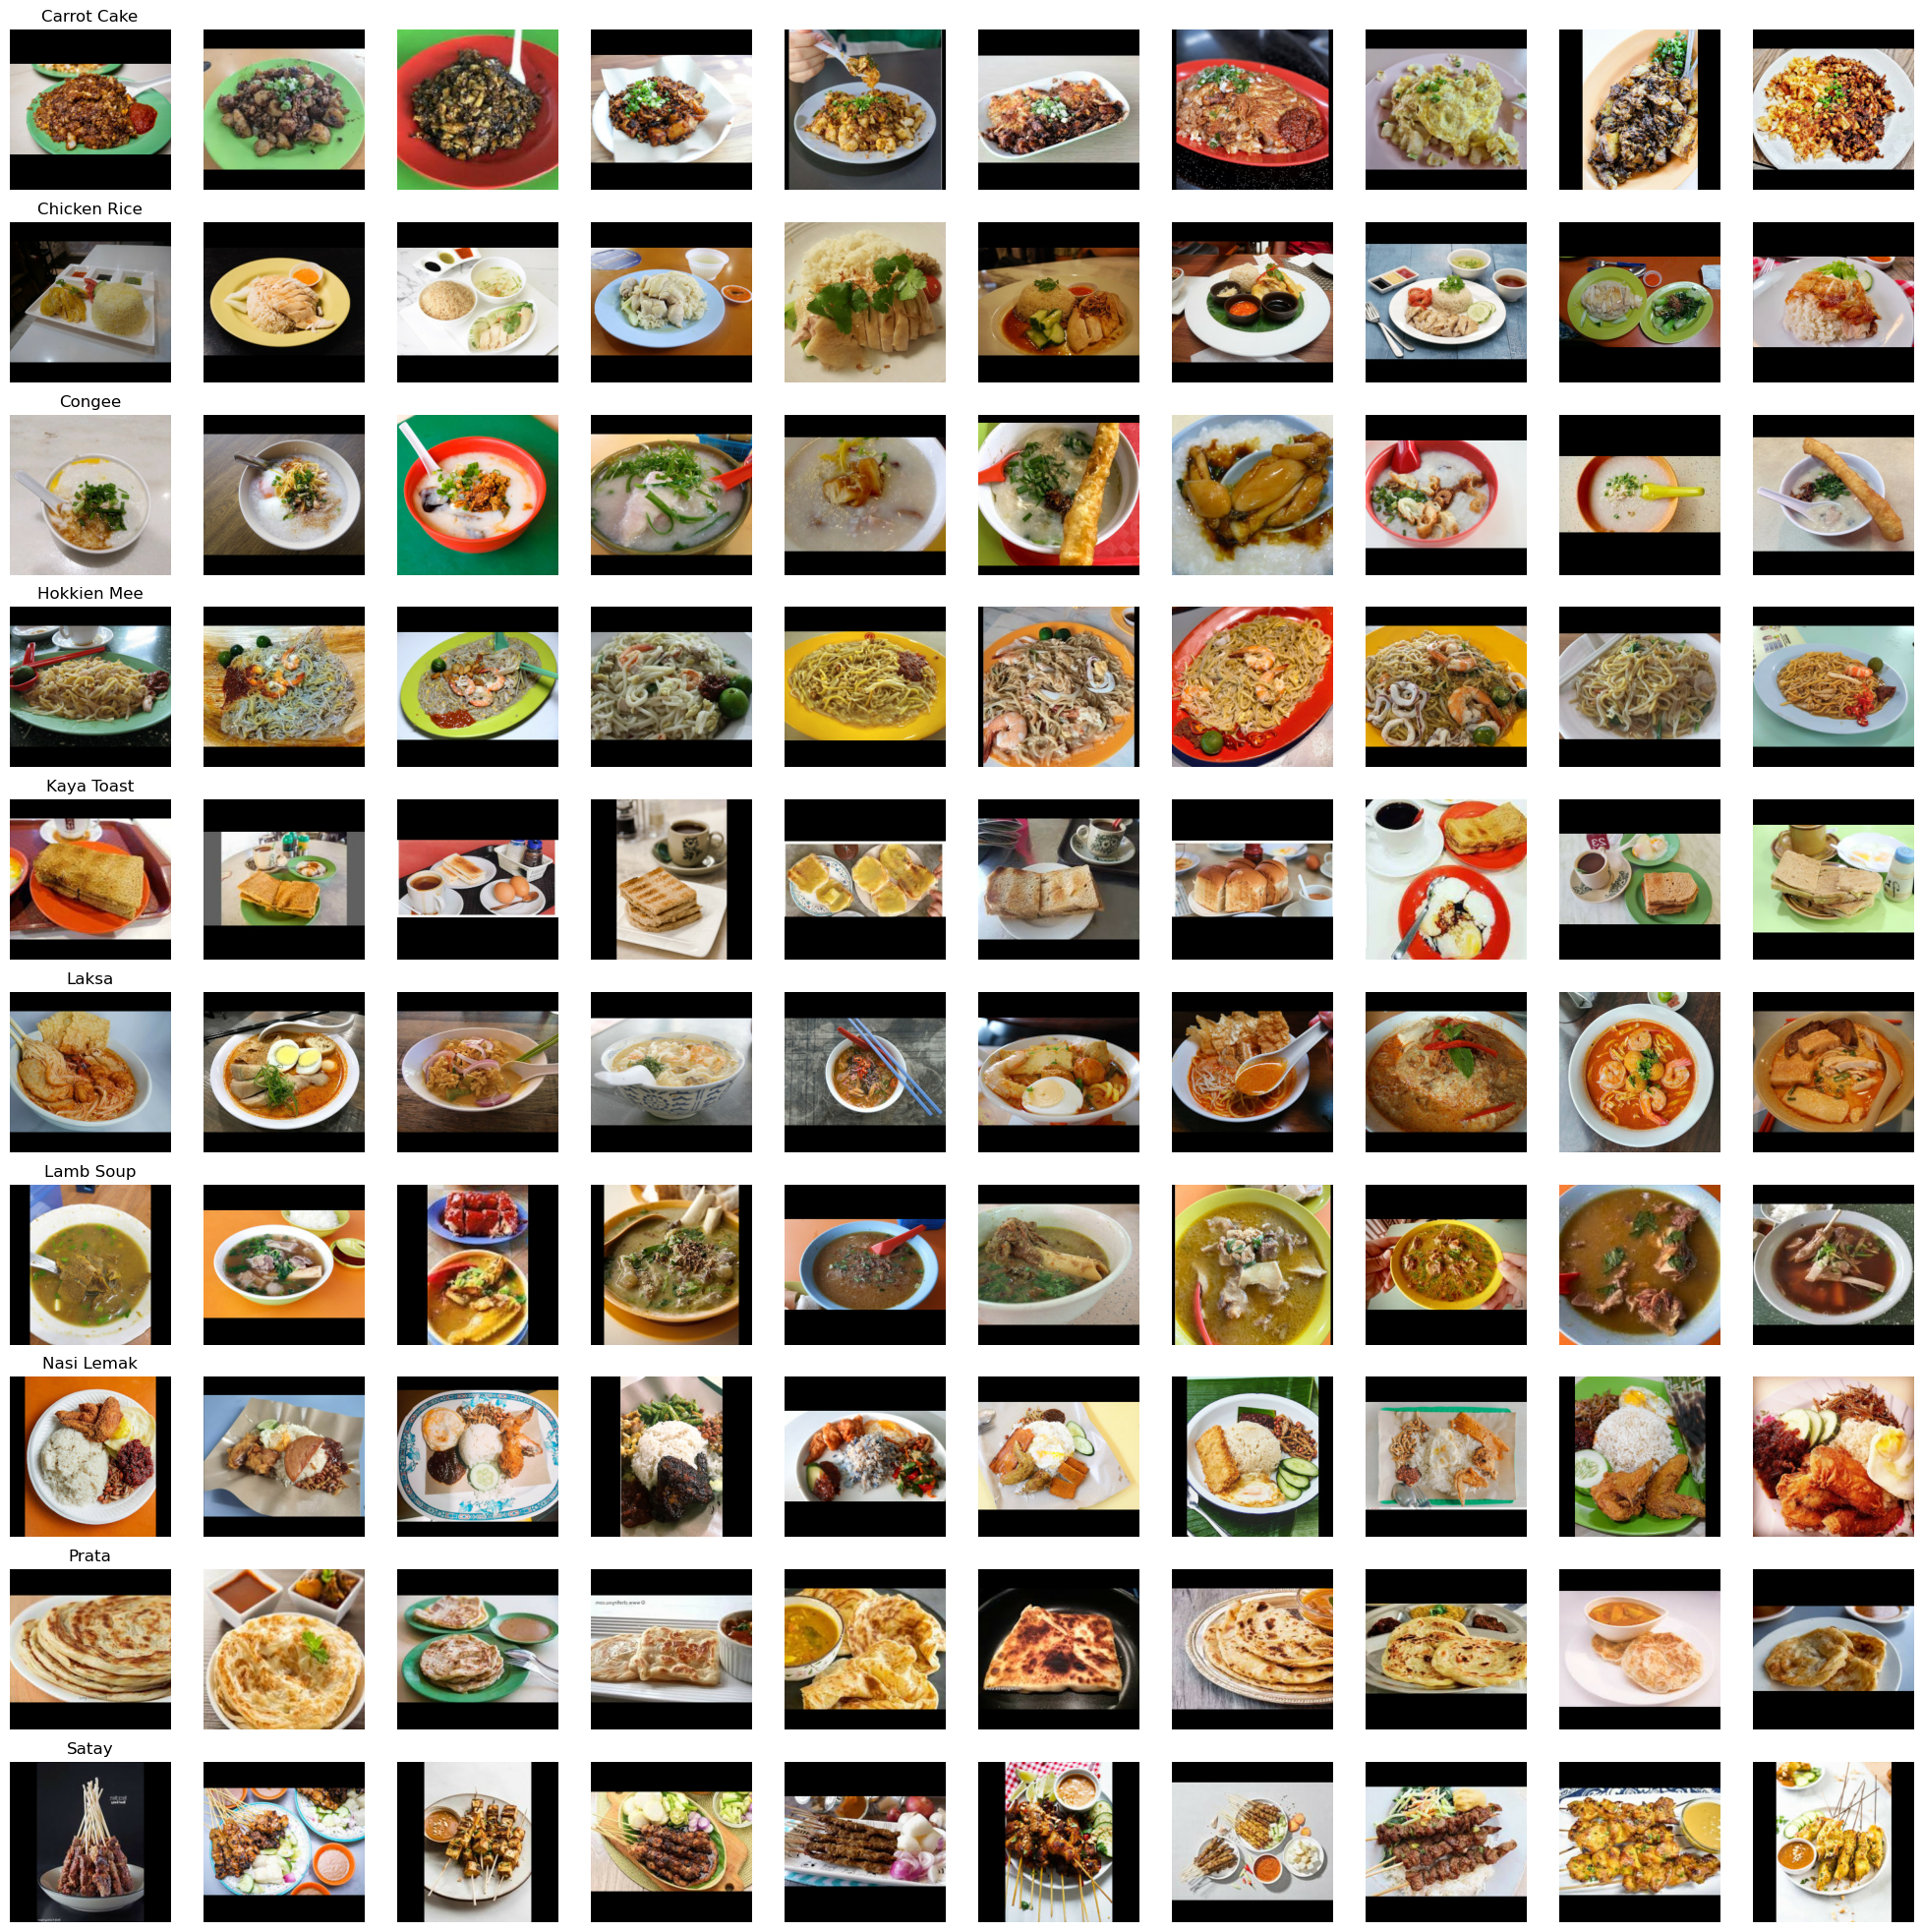

In [365]:
examplesByClass(
  oversampled_ds.shuffle(
    target_count * num_classes,
    seed=oversampled_ds_examples_shuffle_seed
  ),
  10
)

#### Now the classes should be balanced

In [366]:
oversampled_ds = ds.concatenate(oversampled_ds)
oversampled_labels, _, oversampled_class_counts = classInfos(oversampled_ds)

for label, count in enumerate(oversampled_class_counts):
  print(f"{label}: {count}")

0: 144
1: 144
2: 144
3: 144
4: 144
5: 144
6: 144
7: 144
8: 144
9: 144


### Training Augmentations

Nothing too aggressive.

In [367]:
crop_pct = .9

crop_size = int(np.round(image_shape[0] * crop_pct))

In [381]:
random_contrast_seed = randint()
random_crop_seed = randint()
random_rotation_seed = randint()
random_zoom_seed = randint()

In [368]:
# Will be applied later on training set in Train - Valid - Test
augmentor = tf.keras.models.Sequential(name="Augmentor")

augmentor.add(tf.keras.layers.RandomContrast(
  .1,
  seed=random_contrast_seed
))

augmentor.add(tf.keras.layers.RandomCrop(
  crop_size, crop_size,
  seed=random_crop_seed
))

augmentor.add(tf.keras.layers.RandomRotation(
  .1,
  "constant",
  seed=random_rotation_seed
))

augmentor.add(tf.keras.layers.RandomZoom(
  (-.1, .1),
  fill_mode="constant",
  seed=random_zoom_seed
))

augmentor.add(tf.keras.layers.Resizing(*target_size))

# Model

## Train - Valid -Test

Also, optimize for performance.

In [369]:
batch_size = 32
valid_pct = .1
test_pct = .1

print(f"Batch Size: {batch_size}")

size = len(oversampled_labels)
valid_size = np.round(valid_pct * size)
test_size = np.round(test_pct * size)
train_size = size - valid_size - test_size

def optimize(ds):
  return ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = optimize(mapX(oversampled_ds.take(train_size), augmentor))
valid_ds = optimize(oversampled_ds.skip(train_size).take(valid_size))
test_ds = optimize(oversampled_ds.skip(train_size).skip(valid_size))

print(f"Train Size: {train_size}")
print(f"Valid Size: {valid_size}")
print(f"Test Size: {test_size}")

Batch Size: 32
Train Size: 1152.0
Valid Size: 144.0
Test Size: 144.0


## Layers

In [370]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(image_shape))

base_model=tf.keras.applications.DenseNet201(
  include_top=False,
  weights='imagenet'
)
# Freeze Layers
for layer in base_model.layers:
    layer.trainable=False
model.add(base_model)

model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(
  num_classes,
  activation=tf.nn.softmax
))

model.compile(
  tf.optimizers.Adam(),
  tf.losses.categorical_crossentropy,
  tf.metrics.categorical_accuracy
)

In [371]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 global_average_pooling2d_5   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 10)                19210     
                                                                 
Total params: 18,341,194
Trainable params: 19,210
Non-trainable params: 18,321,984
_________________________________________________________________


In [372]:
model_log = model.fit(
  train_ds,
  epochs=50,
  validation_data=valid_ds
)

Epoch 1/50
36/36 [==============================] - 21s 322ms/step - loss: 4.4872 - categorical_accuracy: 0.0530 - val_loss: 1.8508 - val_categorical_accuracy: 0.2778
Epoch 2/50
36/36 [==============================] - 6s 168ms/step - loss: 2.8647 - categorical_accuracy: 0.0469 - val_loss: 1.7738 - val_categorical_accuracy: 0.3403
Epoch 3/50
36/36 [==============================] - 6s 170ms/step - loss: 2.4719 - categorical_accuracy: 0.1102 - val_loss: 1.3431 - val_categorical_accuracy: 0.5972
Epoch 4/50
36/36 [==============================] - 6s 170ms/step - loss: 2.0655 - categorical_accuracy: 0.2153 - val_loss: 1.0605 - val_categorical_accuracy: 0.7500
Epoch 5/50
36/36 [==============================] - 6s 168ms/step - loss: 1.7278 - categorical_accuracy: 0.3524 - val_loss: 0.8542 - val_categorical_accuracy: 0.8125
Epoch 6/50
36/36 [==============================] - 6s 168ms/step - loss: 1.4489 - categorical_accuracy: 0.5026 - val_loss: 0.7061 - val_categorical_accuracy: 0.8264
Epo

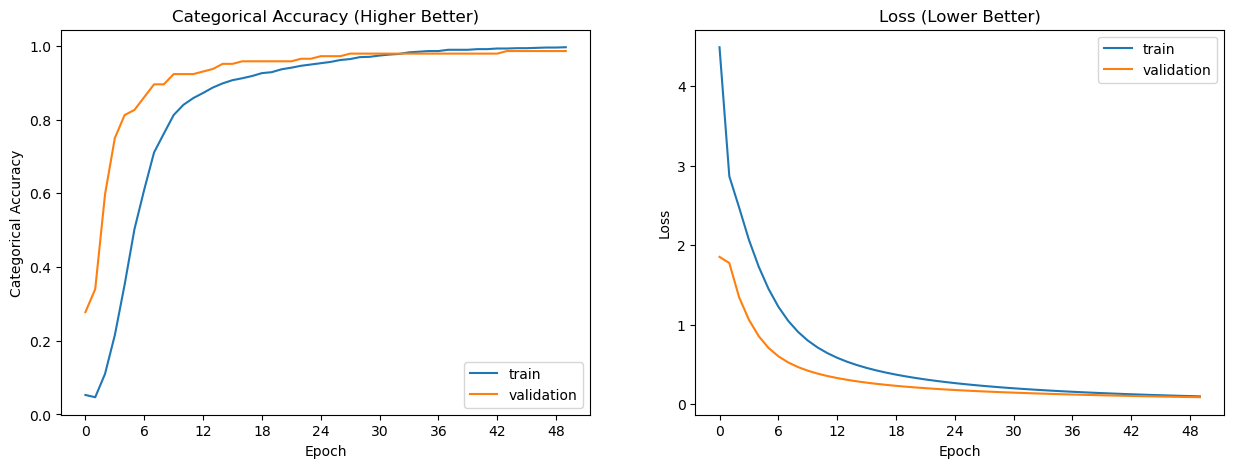

In [373]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['categorical_accuracy'])
ax1.plot(model_log.history['val_categorical_accuracy'])
ax1.set_title('Categorical Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Categorical Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

# Evaluation

In [374]:
test_ds_unbatched = test_ds.unbatch()

## Metrics

In [375]:
y_true = [y for x, y in test_ds_unbatched]
y_pred = model.predict(test_ds, verbose=0)

def testMetric(metric):
  return tf.reduce_mean(metric(y_true, y_pred)).numpy()

test_loss = testMetric(tf.losses.categorical_crossentropy)
test_acc = testMetric(tf.metrics.categorical_accuracy)
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_acc}")

Loss: 0.04785538837313652
Accuracy: 1.0


## Wrongly classified images

In [380]:
# Filter
y_wrong = np.where(np.not_equal(np.argmax(y_true, 1), np.argmax(y_pred, 1)))[0]
num_wrong = len(y_wrong)
if num_wrong:
  # Adapted from https://stackoverflow.com/a/66411957
  table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
      tf.constant(y_wrong),
      tf.ones_like(y_wrong)  # 1's will be casted to True
    ),
    default_value=0  # If index not in table, return 0
  )
  def isWrongHashTableFilter(index, value):
    table_value = table.lookup(index)  # 1 if index in arr, else 0
    index_in_arr =  tf.cast(table_value, tf.bool)  # 1 -> True, 0 -> False
    return index_in_arr
  wrong_ds = test_ds_unbatched.enumerate().filter(isWrongHashTableFilter)

  # Visualize
  rows = 3
  def labelCategorical2ClassName(label_categorical):
    return class_names[tf.argmax(label_categorical)]
  plt.figure(figsize=(rows * 1.3 * sf, np.ceil(num_wrong / rows) * 4 * sf))
  for i, (test_ds_i, (image, label_categorical)) in enumerate(wrong_ds):
    class_name = labelCategorical2ClassName(label_categorical)
    wrong_class_name = labelCategorical2ClassName(y_pred[test_ds_i])
    plt.subplot(num_wrong, rows, i + 1)
    plt.imshow(image)
    plt.title(f"\"{class_name}\" as \"{wrong_class_name}\"")
    plt.axis("off")

No wrongly classified images. Great.